In [1240]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d

In [1241]:
N = 10
X = np.zeros((3,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))
X
A = np.zeros((N,N))
def create_edge(A, i,j, c = 1):
    """
    Function that creates edges between nodes 
    A: Matrix which indicates if there is an edge between nodes 
    i: first node (can be a list) 
    j: second node (can be a list) 
    
    """
    A[i,j] = c
    A[j,i] = c  
edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4], [7, 8], [8,9]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]


In [1242]:
def E_cable_elast_net(X, A, L, k ):
    energy = 0 
    N = np.shape(A)[0]
    for i in range(N):
        for j in range(i, N):
            l_ij = L[i,j]
            if(A[i,j] and np.linalg.norm(X[:,i] - X[:,j]) > l_ij):
                energy += k/(2*l_ij**2) * (np.linalg.norm(X[:,i] - X[:,j]) - l_ij)**2
    return energy

def E_ext(X, mg):
    return np.sum(X[2] * mg)

def gradient_E_cable_elast(x_i, x_j, l_ij, k):
    norm = np.linalg.norm(x_i - x_j)
    if(norm > l_ij):
        return k/(l_ij**2) * (norm - l_ij) * (x_i - x_j) /norm 
    else:
        return np.zeros_like(x_i -x_j)

def gradient_E_ext(x_i,mg_i):
    return np.array([0,0,mg_i])


In [1243]:
def E_bar_elast_net(X, B, L, pg, c = 1):
    energy = 0 
    N = np.shape(A)[0]
    for i in range(N):
        for j in range(i, N):
            if(B[i,j]):
                l_ij = L[i,j]
                energy += c/(2*l_ij**2)*(np.linalg.norm(X[:,i] - X[:,j], 2) - l_ij)**2 + pg/2 *l_ij * (X[:,i][2] + X[:,j][2])
    return  energy

def gradient_E_bar_elast(x_i, x_j, l_ij, c = 1):
    norm = np.linalg.norm(x_i - x_j)
    return c/(l_ij**2) * (norm - l_ij) * (x_i - x_j) /norm 

def gradient_E_bar_grav(x_i, pg):
    return np.array([0,0,pg/2])

In [1244]:
def gradient_E_cable_net(X, A, L, fixed_points, mg,c):
    """
    Function that computes the gradient of cable net
    X: matrix of positions 
    A: matrix which indicates edges 
    """
    N = np.shape(X)[1]
    gradient_E = np.zeros_like(X)
    for i in range(N):
        if(i in fixed_points):
            continue
        gradient_E[:,i] += gradient_E_ext(X[:,i], mg)
        for j in  range(N):
            if(A[i,j]):
                gradient_E[:,i] += gradient_E_cable_elast(X[:,i], X[:,j], L[i,j],c)

    return gradient_E

In [1245]:
def E(X, A, B, L, mg, pg, k = 3, c = 1):
    return E_bar_elast_net(X, B, L, pg, c) + E_cable_elast_net(X, A, L, k) + E_ext(X, mg)

def gradient_E(X, A, B, L, fixed_points, mg, pg, k, c):
    """
    Function that computes the gradient of tensegrity structure
    X: matrix of positions 
    A: matrix which indicates edges 
    """
    N = np.shape(X)[1]
    gradient_E = np.zeros_like(X)
    for i in range(N):
        if(i in fixed_points):
            continue
        gradient_E[:,i] += gradient_E_ext(X[:,i], mg)
        for j in  range(N):
            if(A[i,j] == 1):
                gradient_E[:,i] += gradient_E_cable_elast(X[:,i], X[:,j], L[i,j], k )
            if(B[i,j] == 1):
                gradient_E[:,i] += gradient_E_bar_elast(X[:,i], X[:,j], L[i,j], c) + gradient_E_bar_grav(X[:, i], pg)
    return gradient_E

In [1246]:
def armijo_step(f, gradient_f, X,A,B,L, p_k, fixed_points, mg, pg, k,c, alpha_0 = 1, tol = 1e-3, rho = 1/2):
    alpha  = alpha_0
    steps = 0
    D,N = np.shape(X)
    M = D*N
    gradient = gradient_f(X, A, B, L, fixed_points, mg, pg, k, c)
    f_call = f(X, A, B, L, mg, pg, k, c)
    dot_call = np.dot(np.reshape(p_k, M), np.reshape(gradient, M))
    while(f(X + alpha * p_k, A, B, L, mg, pg, k, c) > (f_call + c * alpha * dot_call) and steps < 100):
        alpha = rho * alpha
        steps +=1  
    return alpha, steps

In [1247]:
def weak_wolfe(f, gradient_f, X,A,B,L, p_k, fixed_points, mg, pg,k,c, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    steps = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X, A, B, L, mg, pg,k,c ) 
    gradient = gradient_f(X, A, B, L, fixed_points, mg, pg, k,c)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(steps < 100):
        steps +=1   
        if(f(X + alpha * p_k, A, B, L, mg, pg, k, c) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max + alpha_min)/2
            
        elif(-np.dot(np.reshape(p_k, M), np.reshape(gradient_f(X + alpha * p_k, A, B, L, fixed_points,mg, pg, k, c),M)) > -(c_2 * dot_call)):
            alpha_min = alpha    
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha),steps
    return alpha, steps

In [1248]:
def strong_wolfe(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    steps = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X, A, B, L, mg, pg, k, c)
    gradient = gradient_f(X, A, B, L, fixed_points, mg, pg, k, c)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(steps < 100):
        steps +=1   
        if(f(X + alpha * p_k, A, B, L, mg, pg,k,c) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max + alpha_min)/2
            
        elif(np.abs(np.dot(np.reshape(gradient_f(X + alpha * p_k, A, B, L, fixed_points,mg,pg, k,c),M), np.reshape(p_k, M))) > np.abs((c_2 * dot_call))):
            alpha_min = alpha
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha), steps
    return alpha, steps

In [1249]:
def gradient_descent(f, gradient_f, X, A, B, L, fixed_points, mg, pg, k, c, tol, alpha_0 = 1, armijo = False, weak_w = False, strong_w = False):
    steps = 0
    Q = 0 
    while(np.linalg.norm(abs(gradient_f(X, A, B, L, fixed_points, mg, pg, k,c))) > tol and steps < 1000):
        steps +=1 
        p_k = -gradient_f(X, A, B, L, fixed_points, mg, pg, k, c)
        if(armijo):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q = armijo_step(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c, alpha_0)
            Q += q
        elif(weak_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha,q = weak_wolfe(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c, alpha_0) 
            Q += q
        elif(strong_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q  = strong_wolfe(f, gradient_f, X, A,B,L, p_k, fixed_points, mg, pg, k, c, alpha_0) 
            Q += q
        else:
            alpha = 1
        X += alpha * p_k
    print(f'number of gradient descent steps = {steps}, number of step size optimization = {Q}, norm of gradient = {np.linalg.norm(gradient_f(X, A, B, L, fixed_points, mg, pg, k, c))}, Energy = {f(X, A, B, L, mg, pg, k,c)}')
    return X

In [1250]:
def BFGS(f, gradient_f, X, A, B, L, fixed_points, mg, pg, k, c, tol, armijo = False, weak_w = False, strong_w = True):
    steps = 0
    Q = 0 
    d,N = np.shape(X)
    M = d*N
    B_k = np.identity(M)
    while(np.linalg.norm(gradient_f(X, A, B, L, fixed_points, mg, pg, k, c)) > tol and steps < 1000):
        p_k = -np.linalg.solve(B_k, np.reshape(gradient_f(X, A, B, L, fixed_points, mg, pg, k, c), M))
        p_k = np.reshape(p_k, (d,N))
        if(armijo):
            step_size,q = armijo_step(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c)
        elif(weak_w):
            step_size,q = weak_wolfe(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c)
        elif(strong_w):
            step_size,q = strong_wolfe(f, gradient_f, X, A, B, L, p_k, fixed_points, mg, pg, k, c)
        else:
            step_size,q = (1,0)
        s = step_size * p_k
        y = gradient_f(X + s, A, B, L, fixed_points, mg, pg, k, c) - gradient_f(X, A, B, L, fixed_points, mg, pg, k, c)
        y = np.reshape(y, M)
        s = np.reshape(s, M)
        alpha = 1/np.dot(y,s)
        beta = -1/np.dot(s, B_k@s)
        B_k += alpha*np.outer(y, y) + beta* np.outer(B_k@s,B_k@s)
        X += step_size*p_k
        steps +=1 
        Q +=q
    print(f'number of BFGS steps = {steps}, number of step size optimization = {Q}, norm of gradient = {np.linalg.norm(gradient_f(X, A, B, L, fixed_points, mg, pg, k, c))}, Energy = {f(X, A, B, L, mg, pg, k, c)}')
    return X

In [1251]:
def plot_cable_net(X,A,ax):
    N = np.shape(X)[1]
    for i in range(N):
        for j in range(i,N):
            if(A[i,j] == 1): 
                x = [X[:,i][0], X[:,j][0]]
                y = [X[:,i][1], X[:,j][1]]
                z = [X[:,i][2], X[:,j][2]]
                ax.scatter(x, y, z,  c='r', marker='o')
                ax.plot(x,y,z, c = 'b')


def plot_bar_net(X,A,ax):
    N = np.shape(X)[1]
    for i in range(N):
        for j in range(i,N):
            if(A[i,j] == 1): 
                x = [X[:,i][0], X[:,j][0]]
                y = [X[:,i][1], X[:,j][1]]
                z = [X[:,i][2], X[:,j][2]]
                ax.scatter(x, y, z,  c='r', marker='o')
                ax.plot(x,y,z, c = 'g', linewidth = '3.0')

In [1252]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))


edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges[:,0], edges[:,1])
fixed_points = [0,1,2,3]


number of BFGS steps = 47, number of step size optimization = 666, norm of gradient = 7.276551586913237e-13, Energy = 0.009285570216250963
[[ 1.      -1.      -1.       1.      -0.70971  0.       0.70971 -0.     ]
 [ 1.       1.      -1.      -1.      -0.      -0.70971  0.       0.70971]
 [ 0.       0.       0.       0.       9.54287  9.54287  9.54287  9.54287]]


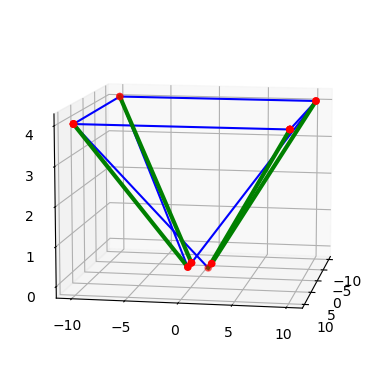

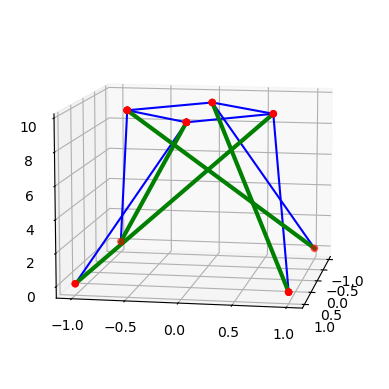

In [1302]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
B = np.zeros((N,N))
a = 1
b = 10
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]
X[:,4] = [b,b,4]
X[:,5] = [-b,b,4]
X[:,6] = [-b,-b,4]
X[:,7] = [b,-b,4]


cable_edges = np.array([[1,4], [2,5], [3,6], [0,7], [4,5], [5,6], [6,7], [7,4]])
bar_edges = np.array([[0,4], [1,5], [2,6], [3,7]])
create_edge(A, cable_edges[:,0], cable_edges[:,1])
create_edge(B, bar_edges[:,0], bar_edges[:,1])
fixed_points = [0,1,2,3]


plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
plot_bar_net(X, B, ax0)
ax0.view_init(10,10)

L = 10*B + 8*A

edges = np.array([[4,5],[5,6],[6,7],[4,7]])
create_edge(L,edges[:,0], edges[:,1], 1)


X_BFGS = BFGS(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg = 0, pg = 0, k = 0.1, c = 1, tol = 1e-12, strong_w=True)

plt.figure()

ax1 = plt.axes(projection = '3d')
plot_cable_net(X_BFGS, A, ax1)
plot_bar_net(X_BFGS, B, ax1)
ax1.view_init(10,10)

np.set_printoptions(precision=5, suppress = True)
print(X_BFGS)

number of gradient descent steps = 130, number of step size optimization = 0, norm of gradient = 9.138594321988915e-09, Energy = 1.166666666666667
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of gradient descent steps = 1000, number of step size optimization = 95008, norm of gradient = 3.272187727186725e-08, Energy = 1.1666666666666663
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of gradient descent steps = 62, number of step size optimization = 1338, norm of gradient = 8.031996197432662e-09, Energy = 1.1666666666666672
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of BFGS steps = 29, number of step size optimization = 129, norm of gradient = 8.56265413717977e-09, Energy = 1.1666666666666663
[[ 5.  -5.  -5.   5.   2

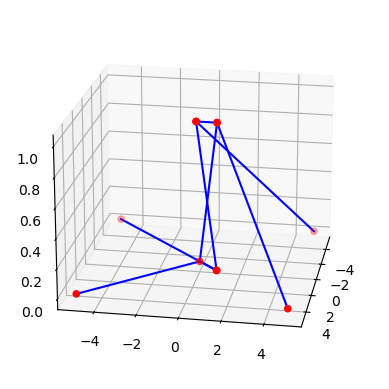

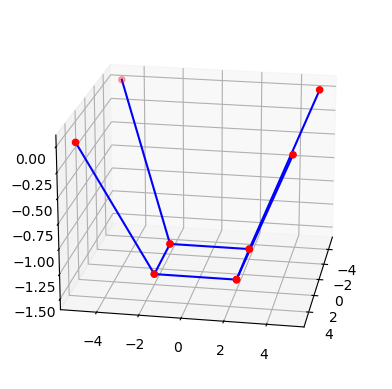

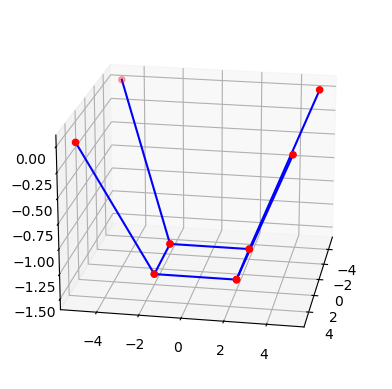

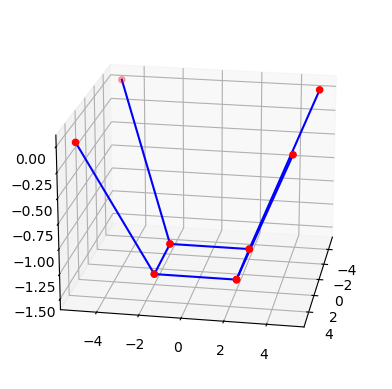

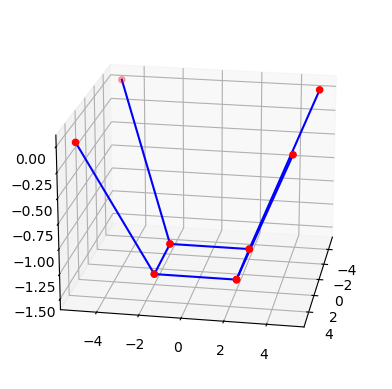

In [1255]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(2, size = np.shape(X[:,4:]))


edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges[:,0], edges[:,1],1)
B = np.zeros_like(A)
L = 3*np.ones_like(A)
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_const_step = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg =1/6, pg = 0, k = 3, c = 0, tol = 1e-8)
plot_cable_net(X_const_step, A, ax1)
ax1.view_init(20,10)
print(X_const_step)

plt.figure()
ax2 = plt.axes(projection = '3d')
X_weak_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg =1/6, pg = 0, k = 3, c = 0, tol = 1e-8, weak_w = True)
plot_cable_net(X_weak_wolfe, A, ax2)
ax2.view_init(20,10)
print(X_weak_wolfe)

plt.figure()
ax3 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg =1/6, pg = 0, k = 3, c = 0, tol = 1e-8, strong_w = True)
plot_cable_net(X_strong_wolfe, A, ax3)
ax3.view_init(20,10)
print(X_strong_wolfe)


plt.figure()
ax4 = plt.axes(projection = '3d')
X_BFGS = BFGS(E,gradient_E, np.copy(X), A, B, L, fixed_points, mg =1/6, pg = 0, k = 3, c = 0, tol = 1e-8, strong_w= True)
plot_cable_net(X_BFGS, A, ax4)
ax4.view_init(20,10)
print(X_BFGS)

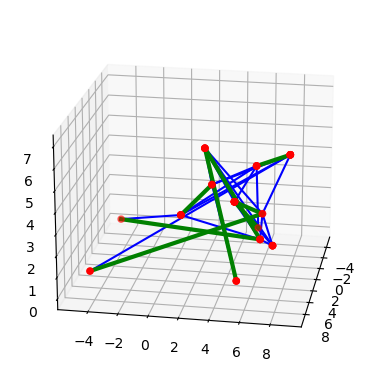

In [1264]:
N = 13
X = np.zeros((3,N))
A = np.zeros((N,N))
B = np.zeros((N,N))
a = 5
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))
#X[:,12] = [0,0,-10]
edges = np.array([[1,5], [2,6], [3,7],[0,4], [4,5], [5,6], [6,7], [4,7], [4,8], [5,9], [6,10], [7,11], [4,8], [8,9],[9,10],[10,11],[11,8], [8,12], [9,12], [10,12], [11,12] ])
bar_edges = np.array([[0,8], [1,9], [2,10], [3,11], [4,6], [5,7], [8, 10], [9,11]])
create_edge(A, edges[:,0], edges[:,1])
create_edge(B, bar_edges[:,0], bar_edges[:,1])
L = 3*np.ones_like(A)
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
plot_bar_net(X, B, ax0)
ax0.view_init(20,10)


number of gradient descent steps = 518, number of step size optimization = 0, norm of gradient = 9.674389577169739e-09, Energy = -3.7248442848391896


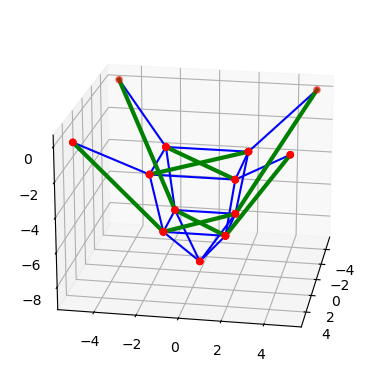

In [1265]:
plt.figure()
ax1 = plt.axes(projection = '3d')
X_const_step = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg = 1/6, pg = 0, k = 3, c = 0, tol = 1e-8)
plot_cable_net(X_const_step,A, ax1)
plot_bar_net(X_const_step, B, ax1)
ax1.view_init(20,10)

number of gradient descent steps = 312, number of step size optimization = 2636, norm of gradient = 8.602222207038256e-09, Energy = -3.7248442848391896


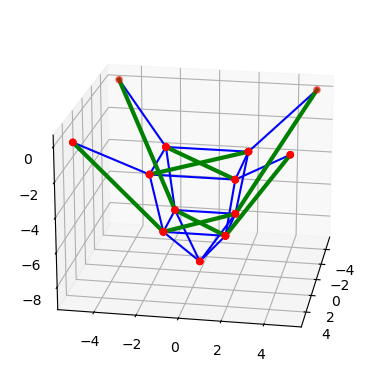

In [1266]:
plt.figure()
ax2 = plt.axes(projection = '3d')
X_armijo = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg = 1/6, pg = 0, k = 3, c = 0, tol = 1e-8, armijo= True)
plot_cable_net(X_const_step,A, ax2)
plot_bar_net(X_const_step,B, ax2)
ax2.view_init(20,10)

number of gradient descent steps = 203, number of step size optimization = 3168, norm of gradient = 5.4050335712643785e-09, Energy = 0.7407636105208724


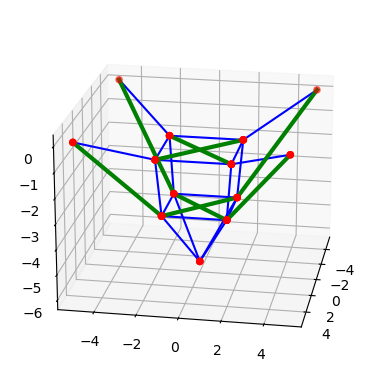

In [1269]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg = 1/6, pg = 0, k = 3, c = 1, tol = 1e-8, strong_w= True)
plot_cable_net(X_strong_wolfe, A, ax4)
plot_bar_net(X_strong_wolfe, B, ax4)
ax4.view_init(20,10)

number of BFGS steps = 76, number of step size optimization = 176, norm of gradient = 6.848576841628714e-09, Energy = -6.708890052973674


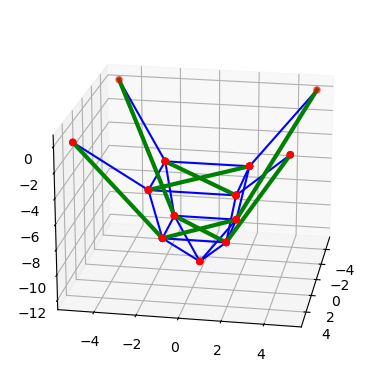

In [1270]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_BFGS = BFGS(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg = 1/6, pg = 0, k = 1, c = 0.1, tol = 1e-8, strong_w = True)
plot_cable_net(X_BFGS, A, ax4)
plot_bar_net(X_BFGS, B, ax4)
ax4.view_init(20,10)